In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import numpy as np

In [42]:
ROOT_ABSPATH = Path("create_plots.ipynb").resolve().parent.parent
LAYERS_METRICS = ROOT_ABSPATH / "data/metrics/layers"
TIMESTEPS_METRICS = ROOT_ABSPATH / "data/metrics/timesteps"
PLOTS_DIR = ROOT_ABSPATH / "data/plots"

LAYERS_METRICS.mkdir(parents=True, exist_ok=True)
TIMESTEPS_METRICS.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def transform_and_extract_metadata(df):
    """
    Reshape a DataFrame by extracting metadata from column names.

    :param df: DataFrame with columns in the format `<model_name>_<layer_idx>_<timestep>_<metric>__*`.
    :return: DataFrame with columns: `value`, `model_name`, `layer_idx`, `timestep`, and `metric`.
    """
    transformed_data = []
    
    for col in df.columns:
        match = re.search(r"(.+?)_(\d+)_(\d+(?:\.\d+)?)[^a-zA-Z]*(.+)__.*", col)
        if match:
            model_name, layer_idx, timestep, metric = match.groups()
            if model_name == "t2i_uncond":
                model_name = "t2i empty caption"
            # Create a DataFrame for each matching column
            transformed_data.append(pd.DataFrame({
                "value": df[col],
                "model_name": model_name,
                "layer_idx": int(layer_idx),
                "timestep": float(timestep),
                "metric": metric,
            }))
    
    # Concatenate all transformsed DataFrames
    result = pd.concat(transformed_data, ignore_index=True)
    return result

In [ ]:
def concat_dfs(dir: Path):
    """
    Concatenate and transform all DataFrames in a directory.

    :param dir: Directory containing CSV files.
    :return: A single concatenated DataFrame with transformed and deduplicated data.
    """
    transformed_dfs = []
    for f in dir.iterdir():
        if f.name != ".DS_Store":
            df = pd.read_csv(f)
            transformed_df = transform_and_extract_metadata(df).drop_duplicates()
            transformed_dfs.append(transformed_df)
    return pd.concat(transformed_dfs).reset_index(drop=True)

In [45]:
layers_df = concat_dfs(LAYERS_METRICS)
ts_df = concat_dfs(TIMESTEPS_METRICS)

In [46]:
uncond_df = ts_df.loc[(ts_df["model_name"] == "uncond") | (ts_df["model_name"] == "t2i empty caption")].reset_index(drop=True)
t2i_df = ts_df.loc[ts_df["model_name"] == "t2i"].reset_index(drop=True)
unclip_df = ts_df.loc[ts_df["model_name"] == "unclip"].reset_index(drop=True)

In [ ]:
def plot_accuracy(df, x_axis='layer', upperbound=None):
    """
    Plot accuracy against layer index or timestep.

    :param df: 
        A DataFrame containing the data to plot. It must include columns like 'value', 
        'layer_idx', 'timestep', and optionally 'metric' and 'model_name'.
    :param x_axis: 
        Specifies the x-axis variable. Use 'layer' for plotting against `layer_idx`, 
        or 'timestep' for plotting against `timestep`.
    :param upperbound: 
        An optional upper bound value. If provided, a red dashed line is drawn at this value.
    """
    if x_axis == 'layer':
        x_col = 'layer_idx'
        xticks = sorted(df['layer_idx'].unique())
        hue_col = 'model_name'
    elif x_axis == 'timestep':
        x_col = 'timestep'
        # xticks = [0, 0.25, 0.5, 0.75, 1]
        xticks = np.arange(0, 1.0625, 0.0625)
        hue_col = 'legend_label'
        df['legend_label'] = df['model_name'] + " (Layer " + df['layer_idx'].astype(str) + ")"
    else:
        raise ValueError("x_axis must be either 'layer' or 'timestep'")
    
    # Plot setup
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=x_col, y='value', hue=hue_col, marker='o')
    
    # Add upperbound line if applicable
    if upperbound is not None:
        plt.axhline(y=upperbound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upperbound})')
        
        # Ensure y-axis includes the upperbound
        y_min, y_max = plt.ylim()  # Get current y-axis limits
        plt.ylim(min(y_min, upperbound), max(y_max, upperbound))

    # Dynamic title and axis labels
    metric_name = " ".join("".join(df["metric"].unique()).split("_")[1:]).capitalize()
    x_label = " ".join(x_col.split("_")).capitalize()
    models = "_".join(list(df['model_name'].unique()))

    # Customize plot
    plt.title(f"{metric_name} vs. {x_label}", fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(f"{metric_name}", fontsize=14)
    plt.xticks(xticks, fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.legend(title="Model Name", fontsize=12, title_fontsize=14)
    plt.grid(True)

    # Save the plot
    plt.tight_layout()
    fname = f"{x_label}_vs_{metric_name}_on_{models}".lower().replace(" ", "_")
    plt.savefig(PLOTS_DIR / f"{fname}.png")
    plt.show()


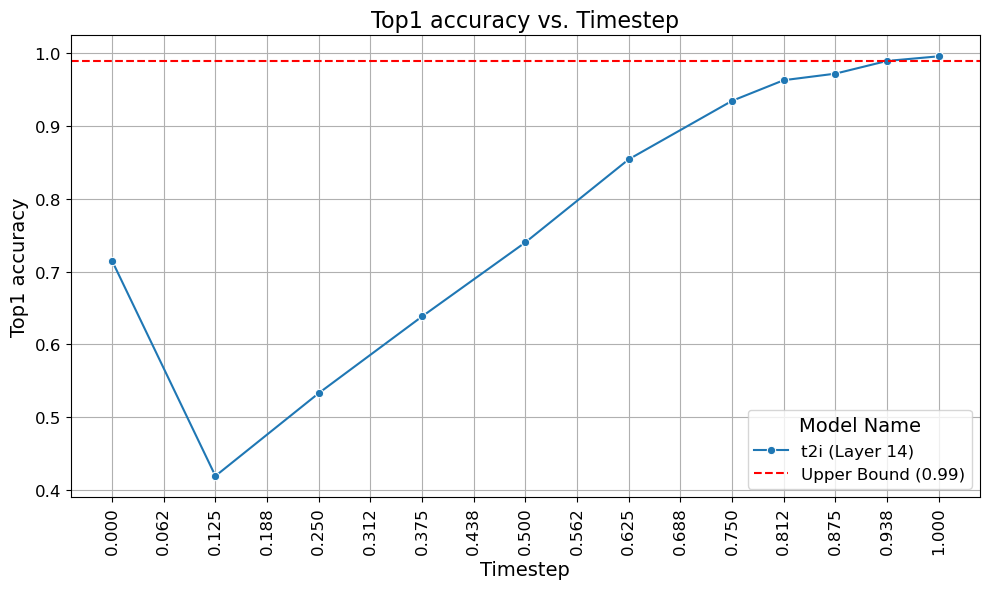

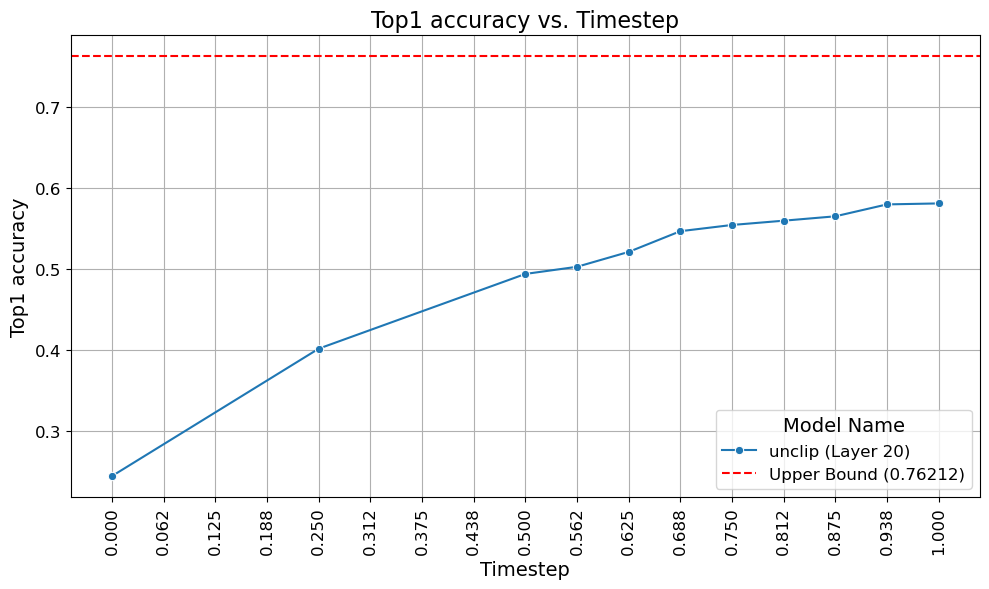

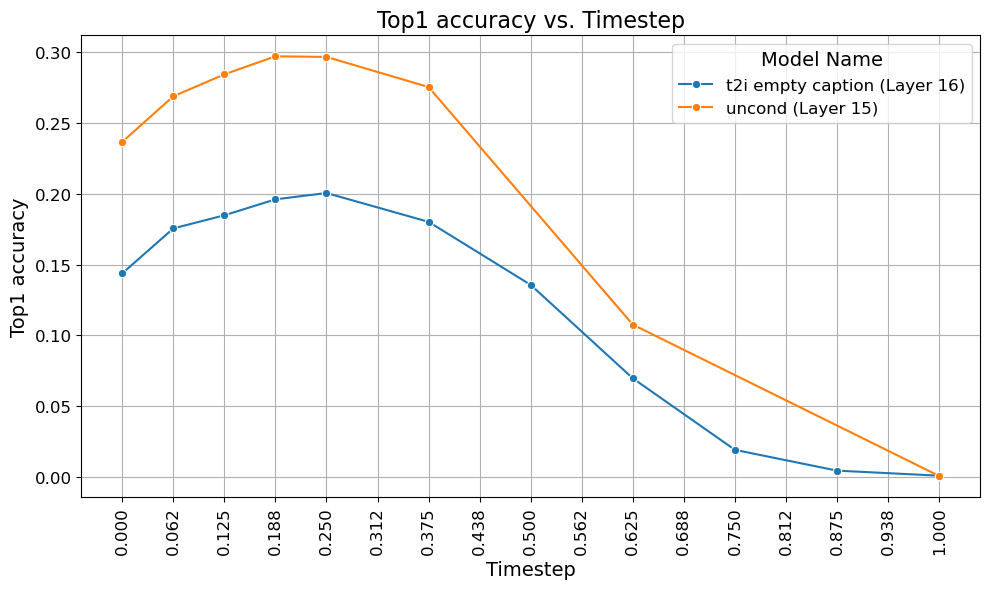

In [ ]:
plot_accuracy(t2i_df, x_axis="timestep", upperbound=0.99)
plot_accuracy(unclip_df, x_axis="timestep", upperbound=0.76212)
plot_accuracy(uncond_df, x_axis="timestep")

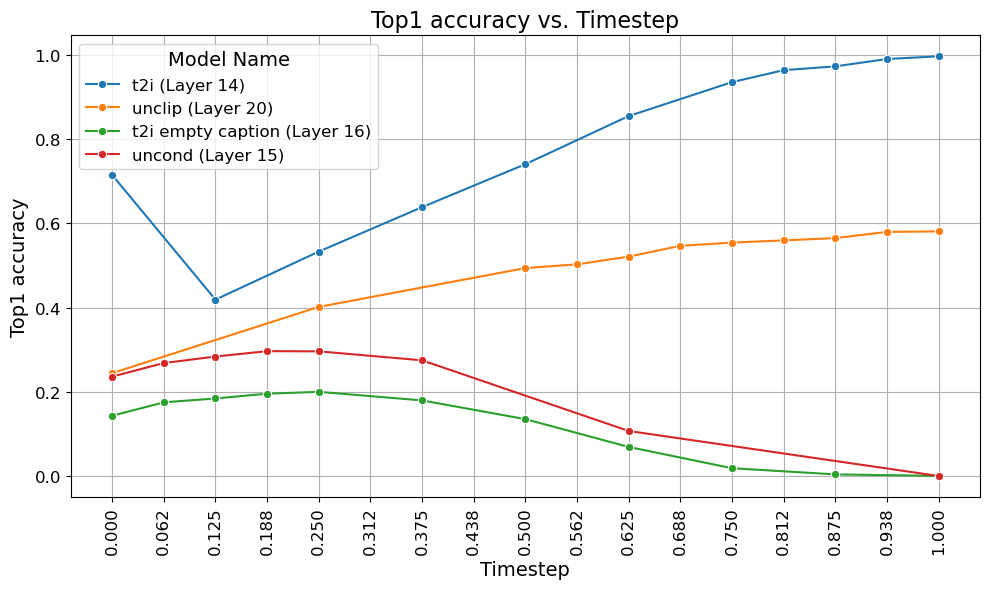

In [49]:
plot_accuracy(ts_df, "timestep")

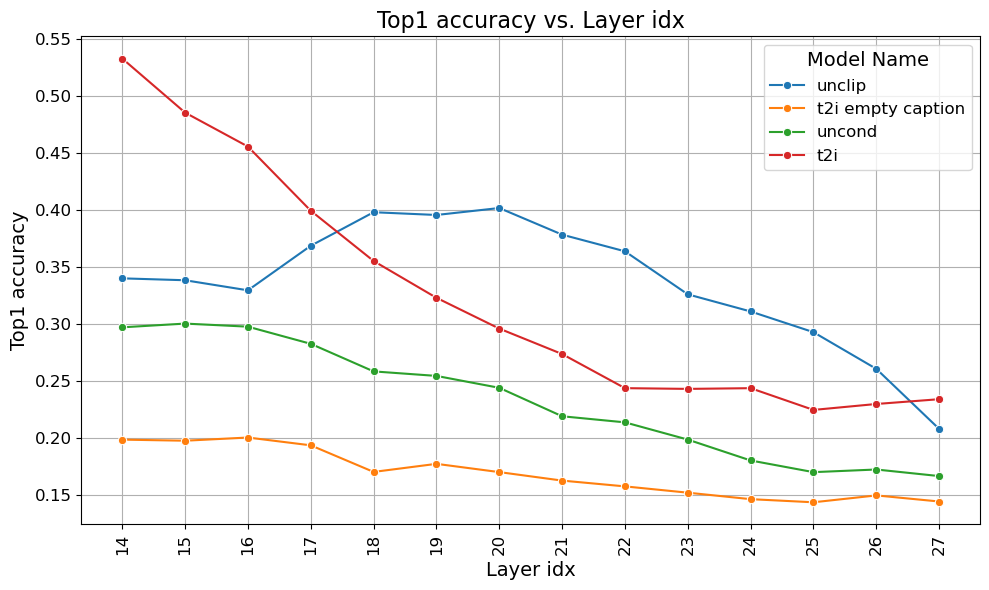

In [50]:
plot_accuracy(layers_df, "layer")